# Example of RubricOE use with randomly generated data in plink binary format

# Import standard modules, and rubricOE modules
* `read_plink` contains a simple binary plink parser, based on `plinkio` (https://github.com/mfranberg/libplinkio)
* `feature_ranking` contains the core routines used in rubricoe
* `rubricoe` contains the high level routines in rubricoe
* `lreb` for Linear Regression with Ridge with Error Bars

In [1]:
#Library
import read_plink
import feature_ranking
import lreb
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC,LinearSVC
import numpy

# Import the RubricOE
from geno4sd import rubricoe

# Usual RubricOE workflow

The very first step in RubricOE's functions splits data into **working** and **validation** sets, where **validation** data is for validation purposes and thus is not used for any of the rest of the computations.
RubricOE's loop in its inner portion computes feature rankings and based on these it computes curves that are used to determine optimal choices of top features. Then it compiles results from all iterations and uses them to determine the final set of top features. Please remember that RubricOE performs all of the computations across iterations using only **working** data. By default, rubricOE uses _Youden's J Statistic_ for curve computation.

In [2]:
# Plink files generated with command: plink --dummy 1000 1000 --out random
df = read_plink.parse_binary_plink("random",dataframe=True, verbose=0) 
X = df[[x for x in df.columns if x!="phenotype"]].values
y = df["phenotype"].values
n_features = X.shape[1]
curve_steps = 1000
step_size = n_features//curve_steps
ranked_features, curves, idx_working, idx_validation = rubricoe.compute_curves(X, y,
                                                                iterations = 10, 
                                                                curve_steps = curve_steps,
                                                                validation_size = .2,
                                                                ranking_test_size = .5,
                                                                scoring_test_size = .5,
                                                                ranking_number_of_folds = 5,
                                                                scoring_number_of_folds = 5,
                                                                clf_ranking = lreb.LinRidgeRegSVD(C = 1.),
                                                                clf_scoring = SVC(kernel = "linear"),
                                                                scoring_n_jobs = 8,
                                                                verbose = 1,
                                                                scoring_adaptive_features=True,
                                                                scoring_tolerance_steps = 20,
                                                                scoring_window_size = 10)
feature_counts = rubricoe.compute_feature_counts(ranked_features,curves,step_size)
top_features = rubricoe.compute_top_features(feature_counts, 1)
print("Top features with threshold 1.0:",df.columns[top_features])

Iteration 1 of 10
Ranking features...
Fold 5 of 5.
Applying workaround for Linear Regression with Error Bars.
Computing score curve...
Early stopping at number of features: 506
Iteration 2 of 10
Ranking features...
Fold 5 of 5.
Applying workaround for Linear Regression with Error Bars.
Computing score curve...
Iteration 3 of 10
Ranking features...
Fold 5 of 5.
Applying workaround for Linear Regression with Error Bars.
Computing score curve...
Early stopping at number of features: 325
Iteration 4 of 10
Ranking features...
Fold 5 of 5.
Applying workaround for Linear Regression with Error Bars.
Computing score curve...
Early stopping at number of features: 469
Iteration 5 of 10
Ranking features...
Fold 5 of 5.
Applying workaround for Linear Regression with Error Bars.
Computing score curve...
Early stopping at number of features: 457
Iteration 6 of 10
Ranking features...
Fold 5 of 5.
Applying workaround for Linear Regression with Error Bars.
Computing score curve...
Early stopping at numb

# Visualization of score curves

We sometimes examine the curves obtained in each repetition and look for patterns in their behavior. In these plots we have marked the number of features that maximize the score function.

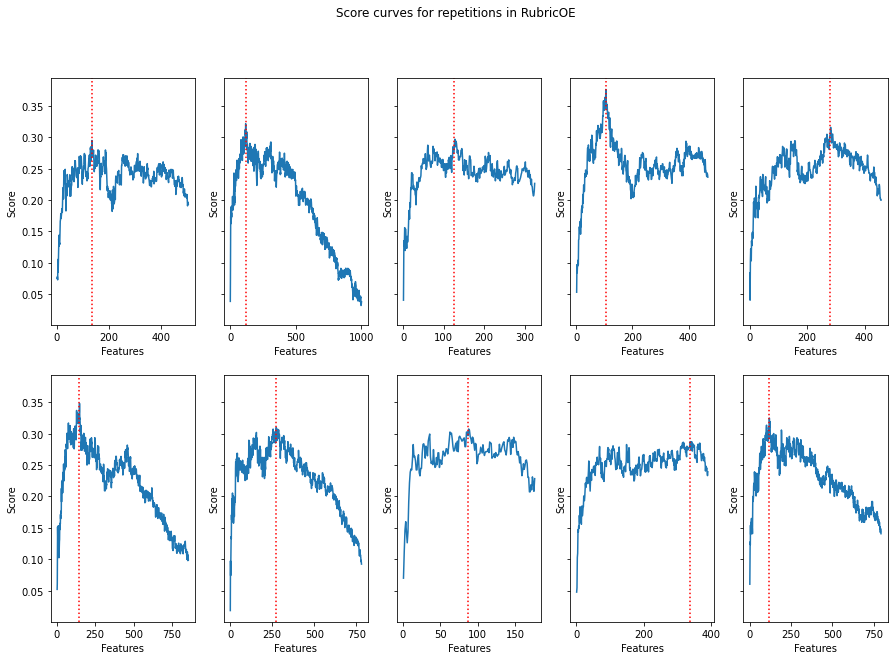

In [3]:
import matplotlib.pyplot as plt
fig, axarr = plt.subplots(2,5, sharey=True) # 2*5 = 10 = number of iterations we ran
fig.set_size_inches(15,10)
for i,c in enumerate(curves):
    domain = range(1,len(c)*step_size + 1,step_size) 
    axarr[i//5,i%5].plot(domain, c)
    axarr[i//5,i%5].axvline(numpy.argmax(c)*step_size,color="red",linestyle=":")
    axarr[i//5,i%5].set_xlabel("Features")
    axarr[i//5,i%5].set_ylabel("Score")
plt.suptitle("Score curves for repetitions in RubricOE")
plt.show()
plt.close()

# Setting up data to measure performance of top features

Since the function `compute_curves` returned indices corresponding to working and validation entries in our data set, we define new sets accordingly.

In [4]:
X_working = X[idx_working]
X_validation = X[idx_validation]
y_working = y[idx_working]
y_validation = y[idx_validation]

## Performance of top features in working and validation data

The module `rubricoe` has the helper function `plot_scores` that gives a statistical view of repeated trainings of a classifier on data using only certain sets of features, such as the top features selected by rubricOE

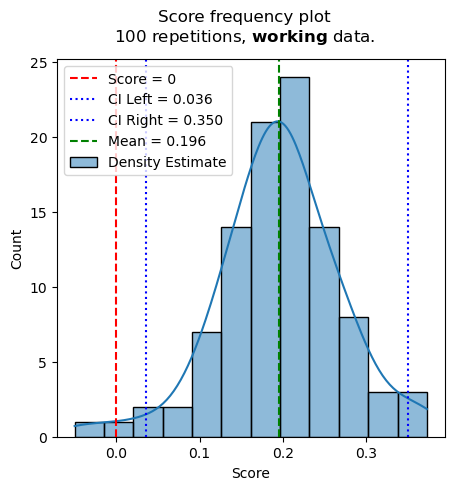

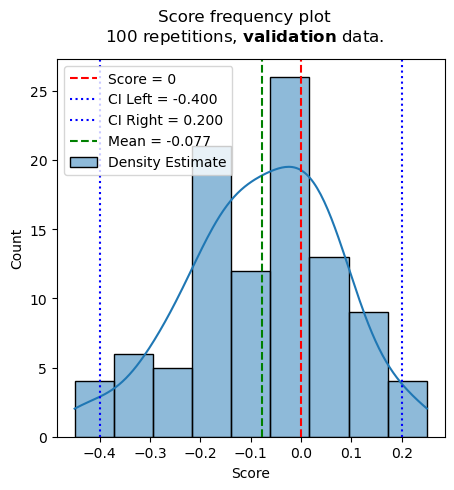

In [8]:
eval_scores = []
for x in range(100):
    x_train, x_test, y_train, y_test = train_test_split(X_working,y_working,test_size=.2,stratify=y_working)
    clf = SVC(kernel="linear")
    clf.fit(x_train[:,top_features],y_train)
    eval_scores.append(feature_ranking.youden_index(y_test,clf.predict(x_test[:,top_features])))
rubricoe.plot_scores(eval_scores,"100 repetitions, $\mathbf{working}$ data.")

eval_scores = []
for x in range(100):
    x_train, x_test, y_train, y_test = train_test_split(X_validation,y_validation,test_size=.2,stratify=y_validation)
    clf = SVC(kernel="linear")
    clf.fit(x_train[:,top_features],y_train)
    eval_scores.append(feature_ranking.youden_index(y_test,clf.predict(x_test[:,top_features])))
rubricoe.plot_scores(eval_scores,"100 repetitions, $\mathbf{validation}$ data.")

As we can see above, the mean of the scores with **working** data is further away from zero, whereas the mean of the scores with **validation** data is close to zero, indicating overfitting. In this case, since we are working with random data, it means that by chance features present in the **working** data correlate somewhat with the phenotype, as defined by the ranking and classifier, but that same set of features is not correlated with phenotypes for the **validation** data.

Next we see what happens when we use **validation** data with all features.

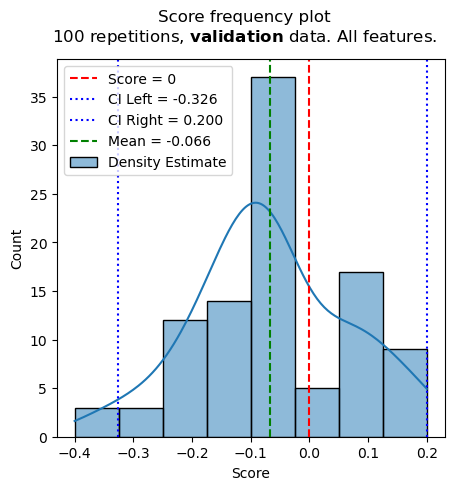

In [7]:
eval_scores = []
for x in range(100):
    x_train, x_test, y_train, y_test = train_test_split(X_validation,y_validation,test_size=.2,stratify=y_validation)
    clf = SVC(kernel="linear")
    clf.fit(x_train,y_train)
    eval_scores.append(feature_ranking.youden_index(y_test,clf.predict(x_test)))
rubricoe.plot_scores(eval_scores,"100 repetitions, $\mathbf{validation}$ data. All features.")